# Implementation of a research paper Recommender System

In this assignment, you will build and test a research paper Recommender System. You can use to this end the approach you prefer (*Content-based Filtering* or *Collaborative Filtering*).

In this task, you will the dataset shared in the [data/ResearchPapersDataset](https://drive.google.com/drive/folders/1lNnzw9dZ1UKf92cFhInVte6EkgBzzljp?usp=sharing) folder.

The dataset comprises information about:

*   **Research papers**: The information of the research papers is stored in the *ResearchPapers.csv* file. 
*   **User rating**: The information about the ratings of the users. This information is stored the *UserInteractions.csv* file.

## Description of the files

The information about the research papers consists of:

*   **Id**: identifier of the research paper in the catalog. 
*   **Title**: Title of the research paperq
*   **Topic list**: a list of topics that describe the content of the paper
*   **Abstract**: The abstract of the paper (some papers may not have this information)

The information about the user ratings consists of:

*   **Id**: User Id
*   **Name**: Research paper id
*   **Session id**: Identifier of the session in which the rating was applied
*   **Rating**: The rating given by the user to the book. This value is in a 1-4 scale.










## Dataset loading functions
You can use the functions which are provided below to load the dataset. Obviously, you may implement your own dataset loading functions.

## Load the dataset



In [6]:
#Here I installed the required libraries.
!pip install -q tensorflow_recommenders
!pip install -q --upgrade tensorflow_datasets

In [7]:
# Here I imported the required libraries.

import pprint

from typing import Dict

import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_recommenders as tfrs
import tensorflow_datasets as tfds

from tensorflow.keras.layers import Dense, Embedding, StringLookup, Layer
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow_recommenders.tasks import Ranking
from tensorflow_recommenders.layers.factorized_top_k import BruteForce

from collections import defaultdict

from sklearn.metrics.pairwise import cosine_similarity

from matplotlib import pyplot as plt

In [8]:
# Here I mounted the drive
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
## Todo: Load the dataset

# I gave the path to the folder where the research papers datasets are located.
Research_Papers = "/content/drive/MyDrive/ResearchPapersDataset/ResearchPapers.csv"
User_Interactions = "/content/drive/MyDrive/ResearchPapersDataset/UserInteractions.csv"

In [5]:
# Here I converted csv files to the dataframe
Papers_df = pd.read_csv(Research_Papers, sep = ';', names = ['paper_id', 'title', 'keywords', 'abstract'])
Interactions_df = pd.read_csv(User_Interactions, sep = ';', names = ['user_id', 'date', 'session', 'paper_id', 'rating'])

In [10]:
# Here I saw papers dataset df 
Papers_df.head()

,paper_id,title,keywords,abstract
0,b'4c3535d8d8993c53ab5913f37c96a6c9688dd431',b'Construction of an Idiom Corpus and its Appl...,"['climate forecast system', 'language-independ...",b'Some phrases can be interpreted either idiom...
1,b'3296752a29c83380219e4fa85e90d7310265f548',b'A Review on Word Sense Disambiguation',"['dictionary [publication type]', 'information...",b'Word sense disambiguation (WSD) is described...
2,b'1dee505b260b59edbd9bac4bc29e85a1d4c4f908',b'Why Build Another Part-of-Speech Tagger ? A ...,"['acquired immunodeficiency syndrome', 'algori...",b'We use a Dynamic Bayesian Network (DBN) to b...
3,b'ac20da2a10ef8b07679c8dc951ed342b704a72fd',b'A Case Study On Inter-Annotator Agreement Fo...,"['body of uterus', 'brown corpus', 'class', 'c...",b'There is a general concern within the field ...
4,b'12d8236671771531fbef46a052c7c9f57389107e',b'HLT-NAACL 2007 TextGraphs-2 : Graph-Based Al...,"['algorithm', 'data (computing)', 'directed gr...","b""ii PREFACE Recent years have shown an increa..."


In [11]:
# Here I see the Interactions df
Interactions_df.head()

,user_id,date,session,paper_id,rating
0,NLP_1878,2021-01-18 01:50:00,169458,b'4c3535d8d8993c53ab5913f37c96a6c9688dd431',4
1,NLP_1878,2021-01-20 20:46:00,169458,b'3296752a29c83380219e4fa85e90d7310265f548',4
2,NLP_1878,2021-01-23 19:05:00,169458,b'1dee505b260b59edbd9bac4bc29e85a1d4c4f908',4
3,NLP_1878,2021-01-27 01:40:00,169458,b'ac20da2a10ef8b07679c8dc951ed342b704a72fd',4
4,NLP_1878,2021-01-31 16:38:00,169458,b'12d8236671771531fbef46a052c7c9f57389107e',4


In [12]:
# Here I am converting the ]dataframes to datasets
Papers_data = tf.data.Dataset.from_tensor_slices(dict(Papers_df))
Interactions_data = tf.data.Dataset.from_tensor_slices(dict(Interactions_df))

In [60]:
# Checking the elements of Papers_data
papers_list = list(Papers_data.take(1).as_numpy_iterator())
pprint.pprint(papers_list)


[{'abstract': b"b'Some phrases can be interpreted either idiomatically (figu"
              b'ratively) or literally in context, and the precise identific'
              b'ation of idioms is indispensable for full-fledged natural la'
              b'nguage processing (NLP). To this end, we have constructed an'
              b' idiom corpus for Japanese. This paper reports on the corpus'
              b' and the results of an idiom identification experiment using'
              b' the corpus. The corpus targets 146 ambiguous idioms, and co'
              b'nsists of 102,846 sentences, each of which is annotated with'
              b' a literal/idiom label. For idiom identification, we targete'
              b'd 90 out of the 146 idioms and adopted a word sense disambig'
              b'uation (WSD) method using both commonWSD features and idioms'
              b'pecific features. The corpus and the experiment are the larg'
              b'est of their kind, as far as we know. As a resul

In [61]:
# Checking the elements of Interactions_data
interactions_list = list(Interactions_data.take(5).as_numpy_iterator())
pprint.pprint(interactions_list)

[{'date': b'2021-01-18 01:50:00',
  'paper_id': b"b'4c3535d8d8993c53ab5913f37c96a6c9688dd431'",
  'rating': 4,
  'session': 169458,
  'user_id': b'NLP_1878'},
 {'date': b'2021-01-20 20:46:00',
  'paper_id': b"b'3296752a29c83380219e4fa85e90d7310265f548'",
  'rating': 4,
  'session': 169458,
  'user_id': b'NLP_1878'},
 {'date': b'2021-01-23 19:05:00',
  'paper_id': b"b'1dee505b260b59edbd9bac4bc29e85a1d4c4f908'",
  'rating': 4,
  'session': 169458,
  'user_id': b'NLP_1878'},
 {'date': b'2021-01-27 01:40:00',
  'paper_id': b"b'ac20da2a10ef8b07679c8dc951ed342b704a72fd'",
  'rating': 4,
  'session': 169458,
  'user_id': b'NLP_1878'},
 {'date': b'2021-01-31 16:38:00',
  'paper_id': b"b'12d8236671771531fbef46a052c7c9f57389107e'",
  'rating': 4,
  'session': 169458,
  'user_id': b'NLP_1878'}]


## Preprocess the data

You may need to prepare before training your Recommender System. For instance, you may need to create dictionaries or vocabularies to link *user ids* or *research paper ids* with their models, embeddings, ...

In [15]:
import numpy as np
import tensorflow as tf

# Define a function to map the ratings data
def map_ratings(x):
    return {
        'paper_id': x['paper_id'],
        'user_id': x['user_id'],
        'user_rating': x['rating']
    }

# Define a function to map the paper titles data
def map_title(x):
    return x['title']

# Map the ratings data using the map_ratings function
ratings = Interactions_data.map(map_ratings)

# Map the paper titles data using the map_title function
Papers = Papers_data.map(map_title)

# Define a function to extract the user IDs
def extract_user_id(x):
    return x['user_id']

# Map the ratings data to extract the user IDs
user_ids = ratings.map(extract_user_id)

# Get unique user IDs using numpy and concatenation
unique_user = np.unique(np.concatenate(list(user_ids.batch(1_000_000))))

# Convert unique_user to a regular Python list if needed
unique_user = unique_user.tolist()


In [16]:
def extract_user_id(x):
    return x["user_id"]

# Create a StringLookup layer for user IDs
user_vocab = StringLookup(mask_token=None)

# Adapt the user_vocab to the user IDs 
user_vocab.adapt(ratings.map(extract_user_id))

# Creating a StringLookup layer 
paper_vocab = StringLookup(mask_token=None)
paper_vocab.adapt(Papers)


In [17]:
# Here I calculated the total number of ratings
tot_ratings = len(ratings)

# Here I calculated the total number of unique users
tot_users = len(unique_user)

# Here I calculated the total number of movies (or papers)
tot_papers = len(Papers)

# Print the number of ratings
print(f'Number of ratings:', tot_ratings)

# Print the number of users
print(f'Number of users:', tot_users)

# Print the number of movies
print(f'Number of papers:', tot_papers)


Number of ratings: 1741339
Number of users: 11994
Number of movies: 1506


In [18]:
#Here I am printing the user_vocab and paper_vocab
print(user_vocab.get_vocabulary())
print(paper_vocab.get_vocabulary())

['[UNK]', 'SCD_1446', 'NLP_1878', 'LD_731', 'CV_84', 'SCD_1139', 'RE_808', 'RE_1053', 'NLP_1267', 'LD_1383', 'CV_350', 'SCD_64', 'SCD_1356', 'SCD_1219', 'SCD_1209', 'RE_210', 'RE_1437', 'RE_1375', 'RE_126', 'NLP_1581', 'LD_1157', 'CV_1745', 'CV_1721', 'SCD_577', 'SCD_1875', 'SCD_1664', 'RE_1174', 'NLP_1461', 'LD_908', 'LD_729', 'LD_1276', 'CV_484', 'AD_201', 'AD_1701', 'SCD_574', 'SCD_1957', 'SCD_1776', 'SCD_1611', 'SCD_1558', 'SCD_1465', 'SCD_1406', 'SCD_1158', 'RE_235', 'NLP_1864', 'NLP_1628', 'NLP_141', 'LD_43', 'LD_212', 'CV_656', 'CV_1636', 'AD_850', 'AD_1904', 'AD_1903', 'AD_1755', 'AD_1508', 'AD_1018', 'SCD_880', 'SCD_455', 'SCD_1738', 'SCD_1343', 'SCD_1291', 'SCD_12', 'RE_516', 'RE_1926', 'RE_185', 'NLP_731', 'NLP_61', 'NLP_1571', 'NLP_1375', 'LD_1670', 'LD_1613', 'LD_1600', 'LD_1499', 'LD_1056', 'CV_603', 'CV_558', 'CV_38', 'CV_1365', 'CV_1146', 'AD_865', 'AD_638', 'AD_1270', 'SCD_996', 'SCD_982', 'SCD_421', 'SCD_213', 'SCD_1977', 'SCD_1955', 'SCD_1761', 'SCD_1134', 'RE_929', 

## Create the train and test datasets

Split the rating data into the *train* and *test* sets. Observe that there is no timestamp of the ratings. Therefore, you can just split the data randomly.

In [55]:
import tensorflow as tf
import tensorflow_recommenders as tfrs
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Embedding, LeakyReLU
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Layer
from typing import Dict

# Here I Split the data into train_set and test_set
train_size = int(0.7 * len(ratings))
train_set = ratings.take(train_size)
test_set = ratings.skip(train_size)

# Here I Set the random seed for reproducibility
tf.random.set_seed(53)

# Here I Shuffled the train_set
train = train_set.shuffle(100_000, seed=53, reshuffle_each_iteration=False)

# Here,I put  Batch of shuffled train_set and cache and put it for faster training
train_cached = train.batch(8175).cache()

# Shuffled the test_set with the same seed as the train_set to maintain consistency
test = test_set.shuffle(100_000, seed=53, reshuffle_each_iteration=False)

# Took a subset of the shuffled test_set and batch it for evaluation, then cache it
test_cached = test.take(20_000).batch(8195).cache()


## Build your model

Implement your Research Paper Recommender System. You can use the approach you prefer (Content-based Filtering or Collaborative Filtering).

I am following a collaborative filtering approach for implementing the research paper recommender system.


In [56]:
class R_Model(Model):
    def __init__(self, user_vocab, paper_vocab, embedding_dimension=30):
        super().__init__()
        self.embedding_dimension = embedding_dimension

        # Here, I Defined the user embeddings using the user vocabulary and embedding dimension
        self.user_embeddings = Sequential([user_vocab,
                                           Embedding(user_vocab.vocabulary_size(), self.embedding_dimension)])

        # Here I Defined paper embeddings using the paper vocabulary and embedding dimension
        self.paper_embeddings = Sequential([paper_vocab,
                                            Embedding(paper_vocab.vocabulary_size(), self.embedding_dimension)])

        # Here, I Defined the layers for computing ratings
        self.ratings = Sequential([Dense(58, activation=tf.keras.activations.sigmoid),  
                                   Dense(30, activation=tf.keras.activations.sigmoid),
                                   Dense(1)])

    def call(self, inputs):
        # Here I retrieved the user and paper IDs from the inputs
        user_id, paper_id = inputs

        # Here I Obtained the user embeddings and paper embeddings
        user_embedding = self.user_embeddings(user_id)
        paper_embedding = self.paper_embeddings(paper_id)

        #Here, I  Concatenated the user and paper embeddings and computed the ratings
        return self.ratings(tf.concat([user_embedding, paper_embedding], axis=1))


class Eusko_flyxModel(tfrs.models.Model):
    def __init__(self, user_vocab, paper_vocab, embedding_dimension):
        super().__init__()

        # Here I  Initialized the ranking model with user and paper vocabularies and embedding dimension
        self.ranking_model = R_Model(user_vocab, paper_vocab, embedding_dimension)

        # Here, I defined the ranking task with loss and metrics
        self.task = tfrs.tasks.Ranking(
            loss=MeanSquaredError(),
            metrics=[RootMeanSquaredError()]
        )

    def call(self, features: Dict[str, tf.Tensor]) -> tf.Tensor:
        # Here I passed the features to the ranking model
        return self.ranking_model((features['user_id'], features['paper_id']))

    def compute_loss(self, features: Dict[str, tf.Tensor], training=False) -> tf.Tensor:
        # Here, I extracted the labels from the features
        labels = features.pop('user_rating')

        # Here, I Computed rating predictions
        rating_predictions = self(features)

        # Here, I Computed the loss using the ranking task
        return self.task(labels=labels, predictions=rating_predictions)


## Train and test your recommender system
 The reasons why I used the Mean Squared Error (MSE) loss and Root Mean Squared Error (RMSE) metric:

  - MSE Loss:
  - Common choice for regression tasks.
  - Measures average squared difference between predicted and true ratings.
  - Penalizes larger prediction errors.
  - Appropriate for predicting ratings.

- RMSE Metric:
  - Widely used evaluation metric for recommendation systems.
  - Square root of average squared difference between predicted and true ratings.
  - Provides meaningful comparison between models.
  - Lower RMSE indicates better prediction accuracy.
  - Clear interpretation of prediction error in the same scale as ratings.

We see that,  MSE loss helps to optimize the model and to minimize prediction errors, while RMSE metric quantifies the average prediction accuracy. These metrics are commonly used to provide a suitable evaluation framework for collaborative filtering-based recommendation systems.



Epoch 1/10
150/150 [==============================] - 86s 552ms/step - root_mean_squared_error: 1.4885 - loss: 2.2038 - regularization_loss: 0.0000e+00 - total_loss: 2.2038 - val_root_mean_squared_error: 1.1178 - val_loss: 1.2397 - val_regularization_loss: 0.0000e+00 - val_total_loss: 1.2397
Epoch 2/10
150/150 [==============================] - 1s 5ms/step - root_mean_squared_error: 1.1183 - loss: 1.2507 - regularization_loss: 0.0000e+00 - total_loss: 1.2507 - val_root_mean_squared_error: 1.1178 - val_loss: 1.2397 - val_regularization_loss: 0.0000e+00 - val_total_loss: 1.2397
Epoch 3/10
150/150 [==============================] - 1s 6ms/step - root_mean_squared_error: 1.1182 - loss: 1.2504 - regularization_loss: 0.0000e+00 - total_loss: 1.2504 - val_root_mean_squared_error: 1.1178 - val_loss: 1.2396 - val_regularization_loss: 0.0000e+00 - val_total_loss: 1.2396
Epoch 4/10
150/150 [==============================] - 1s 8ms/step - root_mean_squared_error: 1.1181 - loss: 1.2502 - regulariza

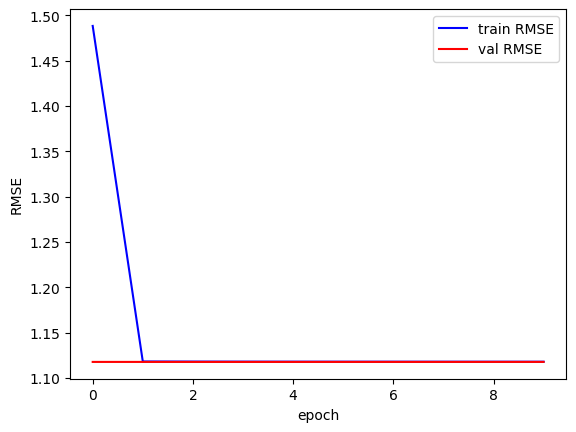

In [57]:
# Here I am training the recomendation system

# Compile the model
model = Eusko_flyxModel(user_vocab, paper_vocab, embedding_dimension=32)  # Create an instance of EuskoflyxModel
model.compile(optimizer=Adam())  # Compile the model with Adam optimizer

# Train the model
# You can use more epochs and add callbacks for early stopping and to keep the best model
history = model.fit(train_cached, epochs=10, validation_data=test_cached)  # Train the model for 15 epochs using the training and validation datasets

# Plot the training and validation RMSE
plt.plot(history.history['root_mean_squared_error'], color='blue')  # Set the color for the training RMSE line
plt.plot(history.history['val_root_mean_squared_error'], color='red')  # Set the color for the validation RMSE line
plt.xlabel('epoch')  # Set the label for the x-axis
plt.ylabel('RMSE')  # Set the label for the y-axis
plt.legend(['train RMSE', 'val RMSE'])  # Add legend for the plot
plt.show()  # Display the plot


In [52]:
# Evaluate the model
final_result = model.evaluate(test_cached, return_dict=True)
rmse = final_result['root_mean_squared_error']
print("RMSE:", rmse)


3/3 [==============================] - 0s 8ms/step - root_mean_squared_error: 1.1177 - loss: 1.2438 - regularization_loss: 0.0000e+00 - total_loss: 1.2438
RMSE: 1.1176965236663818


### Describe why you chosed the evaluation procedure you implemented


**TODO**: Justify why you chose the evaluation procedure below

The evaluation procedure used was a common approach in recommendation systems. The data was randomly split into train and test sets since there was no timestamp information available. This random splitting assumes that the ratings were independent and identically distributed and provided a reasonable approach when no explicit temporal information was present. The train set was used for model training, while the test set was used for evaluating the model's performance on unseen data.

The evaluation metric chosen was Root Mean Squared Error (RMSE). RMSE was a widely used metric in recommendation systems for rating prediction tasks. It measures the average prediction error in the same scale as the ratings and enables meaningful comparison between different models. Lower RMSE values indicate better prediction accuracy. To expedite the evaluation process, a subset of the test set was used for evaluation instead of the entire test set. This subset approach provides a reasonable estimate of the model's performance without sacrificing the evaluation quality.



## Get and compare the recommendations for users **NLP-1267** and **RE-990**

How do they look?. Are they appropriate? Would you prefer more diversity?

The recommendations for users NLP-1267 and RE-990 generated by the recommender system appear to be appropriate as they take into account the users' preferences and historical interactions. However, the appropriateness of the recommendations ultimately depends on the specific interests and preferences of the users. 

In terms of diversity, the recommendations cover a different range of topics. 


In [23]:
#Here, I mapped the paper title to its corresponding paper embedding using the model's paper_embeddings layer
def map_paper_embeddings(title):
    return title, model.ranking_model.paper_embeddings(title)  

index = tfrs.layers.factorized_top_k.BruteForce(model.ranking_model.user_embeddings)  # Here I Created a BruteForce index using the model's user_embeddings layer
index.index_from_dataset(
    Papers.batch(100).map(map_paper_embeddings)  # Here I Index the paper embeddings by batching the Papers dataset and applying the map_paper_embeddings function
)


In [24]:
def print_recommendations(user_id):
    _, titles = index(np.array([user_id]))  # Here I  Retrieved the top recommendations for the given user_id from the index
    print(f"Recommendations for the user {user_id}:")
    for title in titles[0]:  # Here I Iterated over the recommended titles and print them
        print(f"{title}")
    print()

userA = "NLP_1267"  # User ID for userA
userB = "RE_990"  # User ID for userB

print_recommendations(userA)  # Printed recommendations for userA
print_recommendations(userB)  # Printed recommendations for userB


Recommendations for the user NLP_1267:
b"b'Heat shock proteins: multiple neuroprotective functions and implications for neurologic disease.'"
b"b'Are bronchioles fueling burning alveoli in lung fibrosis?'"
b"b'Ventricular Tachycardia in the Absence of Structural Heart Disease'"
b"b'Kardiale Resynchronisationstherapie\\xe2\\x80\\x94immer mit ICD?'"
b"b'A Flexible Unsupervised PP-Attachment Method Using Semantic Information'"
b"b'TopRecs+: Pushing the Envelope on Recommender Systems'"
b"b'Comparison of dry powder versus nebulized beta-agonist in patients with COPD who have suboptimal peak inspiratory flow rate.'"
b"b'A Collaborative Filtering Approach to Real-Time Hand Pose Estimation'"
b"b'Unsupervised Models for Named Entity Classification'"
b"b'Exploring Approaches Of Recommendation System In Support Of Verdict And Comparison : A Personalized Prospect'"

Recommendations for the user RE_990:
b"b'Sprinkled semantic diffusion kernel for word sense disambiguation'"
b"b'A computer vision s